In [3]:
!pip install eli5

     |████████████████████████████████| 112kB 8.2MB/s 


In [4]:
import pandas as pd
import numpy as np
import missingno as msno
import eli5
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from eli5.sklearn import PermutationImportance
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
df_metro = pd.read_csv('/content/drive/MyDrive/london_metro_2020.csv',index_col=0)


Let's see the outcomes of the interactions and their frequency, we've grouped the outcomes into two categories: positive (case is investigated or goes to court) and negative (case not pursued or no subject identified).

In [5]:
df_metro.groupby('Last outcome category').nunique()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Context,Borough,IMD,Outcomes
Last outcome category,,,,,,,,,,,,,,
Awaiting court outcome,19546,12,1,1,12183,12018,9032,4104,4104,13,0,33,3885,1
Court result unavailable,20594,7,1,1,12365,12202,8975,4135,4135,13,0,33,3912,1
Formal action is not in the public interest,3,3,1,1,3,3,3,3,3,3,0,3,3,1
Investigation complete; no suspect identified,553729,12,1,1,53504,50943,33416,4831,4831,13,0,33,4537,1
Local resolution,29490,12,1,1,15616,15360,11133,4337,4337,13,0,33,4103,1
Offender given a caution,5874,12,1,1,4943,4906,3849,2795,2795,13,0,32,2702,1
Offender given a drugs possession warning,336,12,1,1,335,335,291,307,307,3,0,32,307,1
Offender given penalty notice,6955,12,1,1,5327,5286,4122,2622,2622,9,0,33,2539,1
Status update unavailable,90779,9,1,1,33985,32955,22835,4824,4824,13,0,33,4533,1


Our model will predict the outcomes based on the Month, Crime type, Borough and IMD. 

In [7]:
X = df_metro[['Month', 'Crime type', 'Borough', 'IMD']].copy()
y = df_metro['Outcomes'].copy()

le = LabelEncoder()

# We need to encode the categorical variables into our predictors matrix

catColumns = ['Month', 'Crime type', 'Borough']

def categorise(X, catColumns):

  for col in catColumns:
      n = len(X[col].unique())
      if (n > 2):
        Y = pd.get_dummies(X[col])
        Y = Y.drop(Y.columns[0], axis=1)
        X[Y.columns] = Y
        X.drop(col, axis=1, inplace=True)  # drop the original categorical variable (optional)
      else:
        le.fit(X[col])
        X[col] = le.transform(X[col])

categorise(X, catColumns)



We're going to use Logistic Regression as a baseline model so we need to scale the IMD variable so that it's the same size as the others.

In [8]:
def scale(X):
  scaler = MinMaxScaler()
  X[X.columns] = scaler.fit_transform(X)

scale(X)

In [9]:
def split(X,y):
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.6)
  Xtest, XVal, ytest, yval = train_test_split(Xtest, ytest, train_size = 0.5)
  return Xtrain, Xtest, XVal, ytrain, ytest, yval

Xtrain, Xtest, XVal, ytrain, ytest, yval = split(X, y)

In [33]:
model = LogisticRegression()

model.fit(Xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

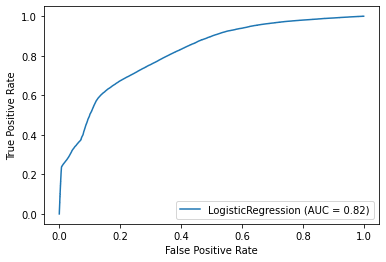

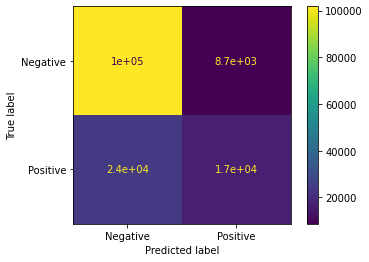

In [34]:
plot_roc_curve(model, XVal, yval)
plot_confusion_matrix(model, XVal, yval)

Not terrible for a baseline model, quite unbalanced but the predictability is alright considering. Let's see which predictors actually pulling their weight.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


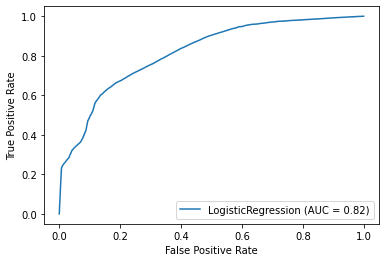

In [39]:
# Drop 'Bourough'

predictors = ['Month', 'Crime type', 'IMD']
catColumns = ['Month', 'Crime type']

X = df_metro[predictors]
categorise(X, catColumns)
scale(X)
Xtrain, Xtest, XVal, ytrain, ytest, yval = split(X, y)

model.fit(Xtrain, ytrain)
plot_roc_curve(model, XVal, yval)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


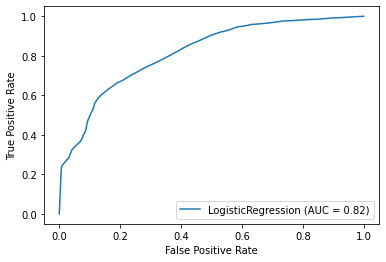

In [45]:
# Drop 'IMD'

predictors = ['Month', 'Crime type']
catColumns = ['Month', 'Crime type']

X = df_metro[predictors]
categorise(X, catColumns)
scale(X)
Xtrain, Xtest, XVal, ytrain, ytest, yval = split(X, y)

model.fit(Xtrain, ytrain)
plot_roc_curve(model, XVal, yval)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

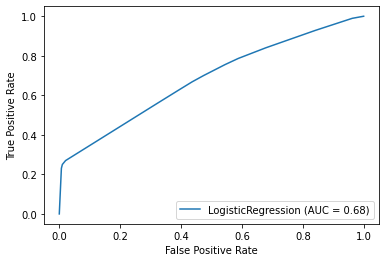

In [46]:
# Drop 'Month'

predictors = ['Crime type']
catColumns = ['Crime type']

X = df_metro[predictors]
categorise(X, catColumns)
scale(X)
Xtrain, Xtest, XVal, ytrain, ytest, yval = split(X, y)

model.fit(Xtrain, ytrain)
plot_roc_curve(model, XVal, yval)

The Bourough and Index of Multiple Deprevation seem to have little predictive value. So we'll settle on a model using the Month and Crime type.

In [10]:
predictors = ['Month', 'Crime type']
catColumns = ['Month', 'Crime type']

X = df_metro[predictors]
categorise(X, catColumns)
scale(X)
Xtrain, Xtest, XVal, ytrain, ytest, yval = split(X, y)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Grid search Logistic regression parameters

In [60]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]


# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(Xtrain, ytrain)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.816878 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.816875 (0.001991) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.816875 (0.001991) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.816876 (0.001991) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.816875 (0.001991) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.816876 (0.001991) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.816876 (0.001991) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.816877 (0.001992) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.816878 (0.001991) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.816878 (0.001992) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.816870 (0.001997) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.816871 (0.001997) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.816873 (0.001997) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.815759 (0.002005) wit

The hyperparameter tuning doesn't enhance the model more that the baseline, let's try a Decision Tree instead.

Create new train test for Decision Tree model

In [6]:
model_T = DecisionTreeClassifier()

In [7]:
model_T.fit(Xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

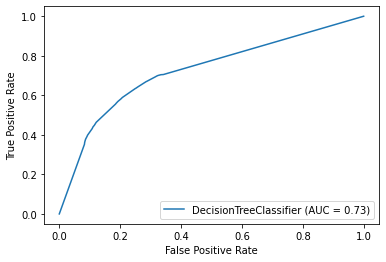

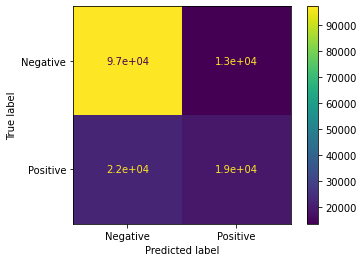

In [8]:
plot_roc_curve(model_T, XVal, yval)
plot_confusion_matrix(model_T, XVal, yval)

Worse than the Logistic regression, let's see if we can tune it to get a better model. It's also quite severely imbalanced so we'll try Under and Over sampling to even it out.

Grid search for Decision Tree

In [11]:
import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler as RUS
from imblearn.over_sampling import RandomOverSampler as ROS

rus = RUS()
ros = ROS()

X_rus, y_rus = rus.fit_sample(X, y)
X_ros, y_ros = ros.fit_sample(X, y)

Xr_train, Xr_test, Xr_Val, yr_train, yr_test, yr_val = split(X_rus, y_rus)
Xro_train, Xro_test, Xro_Val, yro_train, yro_test, yro_val = split(X_ros, y_ros)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [54]:
model = DecisionTreeClassifier()
model_u = model.fit(Xr_train, yr_train)
model_o = model.fit(Xro_train, yro_train)

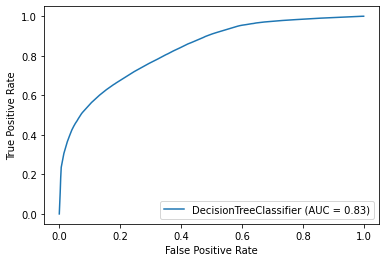

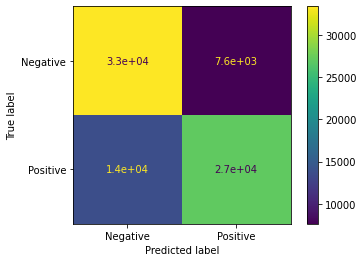

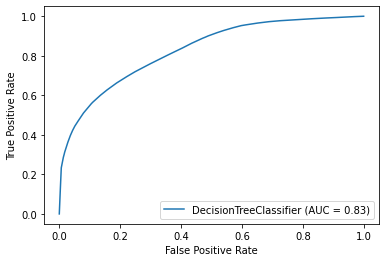

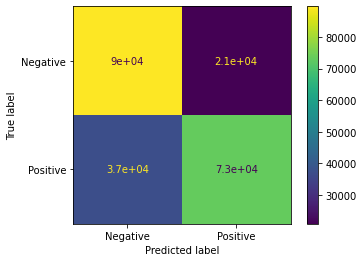

In [55]:
plot_roc_curve(model_u, Xr_Val, yr_val)
plot_confusion_matrix(model_u, Xr_Val, yr_val)
plot_roc_curve(model_o, Xro_Val, yro_val)
plot_confusion_matrix(model_o, Xro_Val, yro_val)

Perf seems to be quite similar but as undersampling doesn't require us to synthetically create data we'll go with that.

In [49]:
model = DecisionTreeClassifier()
min_samples_leaf = [100, 1000, 10000]
max_depth = [1 , 10, 100, 1000]

#Best: 0.826418 using {'max_depth': 100, 'min_samples_leaf': 1000}


# define grid search
grid = dict(min_samples_leaf=min_samples_leaf,max_depth=max_depth)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(Xr_train, yr_train)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.823348 using {'max_depth': 100, 'min_samples_leaf': 100}
0.613246 (0.001339) with: {'max_depth': 1, 'min_samples_leaf': 100}
0.613246 (0.001339) with: {'max_depth': 1, 'min_samples_leaf': 1000}
0.613246 (0.001339) with: {'max_depth': 1, 'min_samples_leaf': 10000}
0.750380 (0.001721) with: {'max_depth': 10, 'min_samples_leaf': 100}
0.750679 (0.001923) with: {'max_depth': 10, 'min_samples_leaf': 1000}
0.723119 (0.001426) with: {'max_depth': 10, 'min_samples_leaf': 10000}
0.823348 (0.000776) with: {'max_depth': 100, 'min_samples_leaf': 100}
0.822098 (0.000365) with: {'max_depth': 100, 'min_samples_leaf': 1000}
0.723119 (0.001426) with: {'max_depth': 100, 'min_samples_leaf': 10000}
0.823348 (0.000776) with: {'max_depth': 1000, 'min_samples_leaf': 100}
0.822098 (0.000365) with: {'max_depth': 1000, 'min_samples_leaf': 1000}
0.723119 (0.001426) with: {'max_depth': 1000, 'min_samples_leaf': 10000}


We found our optimal decision tree and it has a better performance than the Logistic Regression model so we'll use it as our final model.

Final model selection: Decision tree.

In [20]:
model = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1000)
model.fit(Xr_train, yr_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

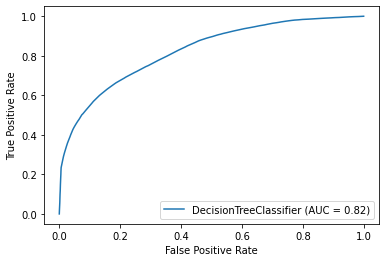

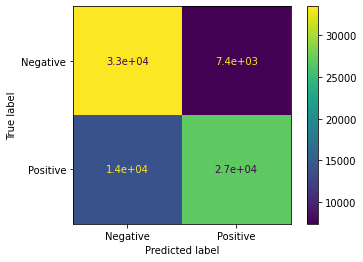

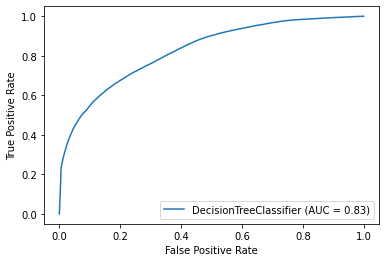

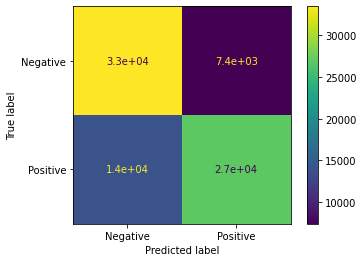

In [22]:
plot_roc_curve(model, Xr_Val, yr_val)
plot_confusion_matrix(model, Xr_Val, yr_val)
plot_roc_curve(model, Xr_test, yr_test)
plot_confusion_matrix(model, Xr_test, yr_test)

Now that we have selected our model we need to select the threshold.

In [59]:
probs = model.predict_proba(Xr_Val)[:,1]
fp_rate, tp_rate, thresholds = roc_curve(yr_val, probs, pos_label='Positive')
print(auc(fp_rate, tp_rate))
print(roc_auc_score(yr_val, probs))


0.8271245169112407
0.8271245169112407


In [89]:
#Write function to calculate Prevalence for each threshold.
Prevalence = np.zeros(len(thresholds))
for i in range(len(thresholds)):
  Preds = probs > thresholds[i]
  Prevalence[i] = np.count_nonzero(Preds == True)/len(Preds)

# We'll put a higher importance on reducing False Negatives as otherwise we might ignore cases which have a higher likelyhood of success
# We'll choose C_fp/C_fn = 0.8
m = (1 - Prevalence)/(Prevalence) * 0.8
m[m == np.inf] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [92]:
def fm(m, TPR, FPR):
  return TPR - m*FPR

threshold = thresholds[np.argmax(fm(m, tp_rate, fp_rate))]
threshold
# Calculated threshold too small -- manually choose larger one.


0.056455571919489446

In [127]:
def predict_with_threshold(model, threshold, X):
  probs = model.predict_proba(X)[:,1]
  return probs > threshold

predictions_val = predict_with_threshold(model, 0.2, Xr_Val)

In [128]:
labels = np.equal(yr_val, 'Positive')

In [129]:
np.equal(predictions_val, labels)

array([ True,  True, False, ..., False,  True,  True])

In [130]:
confusion_matrix(labels,predictions_val) # Plot this somehow

array([[12421, 28578],
       [ 1461, 39385]])

In [132]:
perm = PermutationImportance(model, random_state=1).fit(Xr_Val, yr_val)
eli5.show_weights(perm, feature_names=XVal.columns.to_list())

Weight,Feature
0.1145 ± 0.0016,Drugs
0.0337 ± 0.0004,2020-03
0.0309 ± 0.0007,2020-10
0.0303 ± 0.0009,2020-08
0.0301 ± 0.0011,2020-09
0.0297 ± 0.0010,2020-07
0.0268 ± 0.0017,2020-02
0.0254 ± 0.0007,2020-06
0.0244 ± 0.0004,2020-11
0.0230 ± 0.0007,2020-05


In [2]:
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz

In [19]:
dot_data = export_graphviz(model, out_file=None,
                                feature_names=X.columns,
                                class_names=('Negative', 'Positive'),
                                filled=True)
graph = graphviz.Source(dot_data, format='png')
graph.render()


'Source.gv.png'